# Graph neural networks in PyTorch Geometric

## Conda & jupyter environment setup

Please install Jupyter lab - see the [website](https://jupyter.org/install) for instructions. Similarily with the [Conda](https://docs.conda.io/projects/conda/en/latest/user-guide/install/index.html) package manager.

Let's first create a dedicated Conda environment and link it with Jupyter
```bash
$ conda create --name SSAI-2024-GNN python=3.11
$ conda activate SSAI-2024-GNN
$ conda install -c conda-forge ipykernel
$ python -m ipykernel install --user --name=SSAI-2024-GNN
```

...and install the necessary packages:

```bash
$ conda install -c conda-forge matplotlib numpy scikit-learn
$ conda install -c pytorch pytorch torchvision torchaudio cpuonly
$ conda install -c pyg pyg
```

In [1]:
import numpy as np
import math

from matplotlib import pyplot as plt
import matplotlib.cm as cm
from sklearn.manifold import TSNE

import torch
from torch.nn import Module
import torch_geometric
from torch_geometric.datasets import Planetoid
from torch_geometric.nn import Node2Vec

print("PyTorch version:", torch.__version__)
print("PyTorch geometric version:", torch_geometric.__version__)

PyTorch version: 2.1.2.post103
PyTorch geometric version: 2.5.2


## Finding embeddings with node2vec

To find the embedding let's make from each node of the graph 10 random walks of length 80. To train the skip-gram model, we look at a context window of size 20 - i.e. the number of subsequent nodes in a particular random walk the model looks at. The resulting embedding will then be in the $ \mathbb{R}^{128} $ space. 

In [2]:
walks_per_node = 10
walk_length = 80
context_size = 20
embedding_dim = 32

learning_rate = 0.01
batch_size = 256
epochs = 10

In [3]:
dataset = Planetoid(root = "dataset", name = "Cora", split = "full")
data = dataset[0]
print(data)
print(data.x)
print(data.edge_index)
print(data.y)

Data(x=[2708, 1433], edge_index=[2, 10556], y=[2708], train_mask=[2708], val_mask=[2708], test_mask=[2708])
tensor([[0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.],
        ...,
        [0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.]])
tensor([[ 633, 1862, 2582,  ...,  598, 1473, 2706],
        [   0,    0,    0,  ..., 2707, 2707, 2707]])
tensor([3, 4, 4,  ..., 3, 3, 3])


In [4]:
graph_model = Node2Vec(data.edge_index, embedding_dim, walk_length, context_size, walks_per_node, sparse = True)
optimizer = torch.optim.SparseAdam(list(graph_model.parameters()), lr = learning_rate)
loader = graph_model.loader(batch_size = batch_size, shuffle = True)
graph_model.train()

Node2Vec(2708, 32)

In [5]:
for epoch in range(1, epochs + 1):
    for i, (positive_walk, negative_walk) in enumerate(loader):
        optimizer.zero_grad()
        loss = graph_model.loss(positive_walk, negative_walk)
        loss.backward()
        optimizer.step()
        print(
            f"Epoch: {epoch:02d}",
            f"Step: {i + 1:03d}/{len(loader)}",
            f"Loss: {loss:.4f}"
        )

Epoch: 01 Step: 001/11 Loss: 4.5947
Epoch: 01 Step: 002/11 Loss: 4.4665
Epoch: 01 Step: 003/11 Loss: 4.5099
Epoch: 01 Step: 004/11 Loss: 4.4174
Epoch: 01 Step: 005/11 Loss: 4.2732
Epoch: 01 Step: 006/11 Loss: 4.2323
Epoch: 01 Step: 007/11 Loss: 4.1427
Epoch: 01 Step: 008/11 Loss: 4.1156
Epoch: 01 Step: 009/11 Loss: 4.0255
Epoch: 01 Step: 010/11 Loss: 3.9699
Epoch: 01 Step: 011/11 Loss: 3.9409
Epoch: 02 Step: 001/11 Loss: 3.8127
Epoch: 02 Step: 002/11 Loss: 3.7820
Epoch: 02 Step: 003/11 Loss: 3.6885
Epoch: 02 Step: 004/11 Loss: 3.6542
Epoch: 02 Step: 005/11 Loss: 3.5489
Epoch: 02 Step: 006/11 Loss: 3.5528
Epoch: 02 Step: 007/11 Loss: 3.5052
Epoch: 02 Step: 008/11 Loss: 3.4140
Epoch: 02 Step: 009/11 Loss: 3.3689
Epoch: 02 Step: 010/11 Loss: 3.3045
Epoch: 02 Step: 011/11 Loss: 3.2635
Epoch: 03 Step: 001/11 Loss: 3.2175
Epoch: 03 Step: 002/11 Loss: 3.1712
Epoch: 03 Step: 003/11 Loss: 3.1065
Epoch: 03 Step: 004/11 Loss: 3.0541
Epoch: 03 Step: 005/11 Loss: 2.9828
Epoch: 03 Step: 006/11 Loss:

Let's visualize the embeddings (in $ \mathbb{R}^{128} $) with the t-SNE algoritmu dimensionality reduction algorithm.

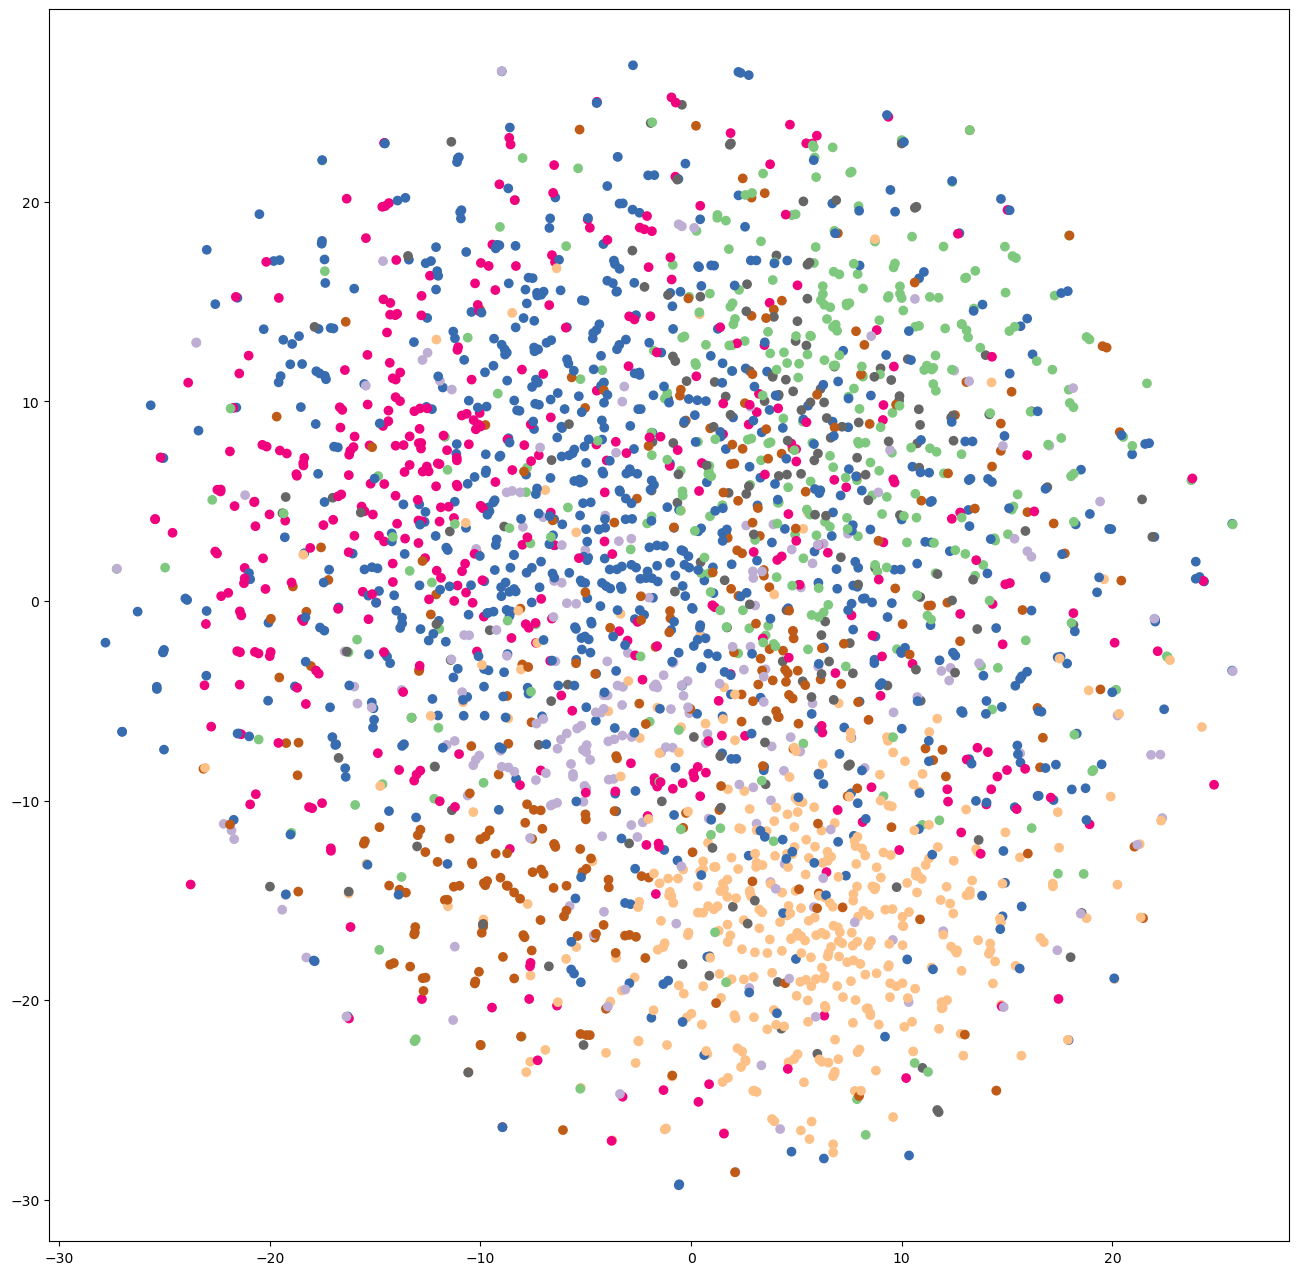

In [6]:
embedding = graph_model().detach()

fig = plt.figure(figsize = (16, 16))
ax = fig.add_subplot(111)
tsne_results = TSNE(n_components = 2).fit_transform(embedding)
ax.scatter(tsne_results[:, 0], tsne_results[:, 1], c = data.y, cmap=cm.Accent)

## Classification using the embeddings

In [7]:
hidden_channels = 256
num_layers = 3
dropout = 0.5
learning_rate_mlp = 0.01
epochs_mlp = 50

In [8]:
class MLPModel(Module):
    def __init__(self, in_channels: int, hidden_channels: int, out_channels: int, num_layers: int, dropout: float) -> None:
        super().__init__()

        self._linear_layers = torch.nn.ModuleList()
        self._linear_layers.append(torch.nn.Linear(in_channels, hidden_channels))
        self._batchnorm_layers = torch.nn.ModuleList()
        self._batchnorm_layers.append(torch.nn.BatchNorm1d(hidden_channels))
        for _ in range(num_layers - 2):
            self._linear_layers.append(torch.nn.Linear(hidden_channels, hidden_channels))
            self._batchnorm_layers.append(torch.nn.BatchNorm1d(hidden_channels))
        self._linear_layers.append(torch.nn.Linear(hidden_channels, out_channels))

        self.dropout = dropout

    def reset_parameters(self) -> None:
        for lin in self._linear_layers:
            lin.reset_parameters()
        for bn in self._batchnorm_layers:
            bn.reset_parameters()

    def forward(self, x: torch.Tensor) -> torch.Tensor:
        for i, lin in enumerate(self._linear_layers[:-1]):
            x = lin(x)
            x = self._batchnorm_layers[i](x)
            x = torch.nn.functional.relu(x)
            x = torch.nn.functional.dropout(x, p=self.dropout, training=self.training)
        x = self._linear_layers[-1](x)
        return torch.log_softmax(x, dim=-1)
    
def train(model: MLPModel, x: torch.Tensor, y_true: torch.Tensor, train_mask: torch.Tensor, optimizer: torch.optim.Optimizer) -> float:
    model.train()

    optimizer.zero_grad()
    out = model(x[train_mask])
    loss = torch.nn.functional.nll_loss(out, y_true[train_mask])
    loss.backward()
    optimizer.step()

    return loss.item()

@torch.no_grad()
def test(model: MLPModel, x: torch.Tensor, y_true: torch.Tensor, mask: torch.Tensor) -> float:
    model.eval()

    out = model(x[mask])
    y_pred = out.argmax(dim = -1)
    return torch.sum(y_pred == y_true[mask]) / y_pred.size(0)

### Classification using only the embeddings

In [9]:
x = embedding
model = MLPModel(x.size(-1), hidden_channels, dataset.num_classes, num_layers, dropout)
optimizer = torch.optim.Adam(model.parameters(), lr = learning_rate_mlp)

In [10]:
for epoch in range(1, epochs_mlp + 1):
    loss = train(model, x, data.y, data.train_mask, optimizer)
    train_accuracy = test(model, x, data.y, data.train_mask)
    test_accuracy = test(model, x, data.y, data.test_mask)
    print(
        f"Epoch: {epoch:02d}",
        f"Loss: {loss:.4f}",
        f"Train accuracy: {100 * train_accuracy:.2f}%",
        f"Test accuracy: {100 * test_accuracy:.2f}%"
    )

Epoch: 01 Loss: 2.0839 Train accuracy: 43.71% Test accuracy: 39.40%
Epoch: 02 Loss: 1.5763 Train accuracy: 54.30% Test accuracy: 47.90%
Epoch: 03 Loss: 1.4161 Train accuracy: 58.28% Test accuracy: 49.00%
Epoch: 04 Loss: 1.2922 Train accuracy: 58.53% Test accuracy: 49.10%
Epoch: 05 Loss: 1.2276 Train accuracy: 60.68% Test accuracy: 50.30%
Epoch: 06 Loss: 1.1692 Train accuracy: 62.67% Test accuracy: 51.60%
Epoch: 07 Loss: 1.1134 Train accuracy: 64.82% Test accuracy: 51.70%
Epoch: 08 Loss: 1.1025 Train accuracy: 66.14% Test accuracy: 52.40%
Epoch: 09 Loss: 1.0726 Train accuracy: 67.80% Test accuracy: 53.00%
Epoch: 10 Loss: 1.0743 Train accuracy: 68.46% Test accuracy: 53.90%
Epoch: 11 Loss: 1.0768 Train accuracy: 68.96% Test accuracy: 53.50%
Epoch: 12 Loss: 1.0216 Train accuracy: 69.95% Test accuracy: 53.60%
Epoch: 13 Loss: 1.0033 Train accuracy: 71.03% Test accuracy: 54.00%
Epoch: 14 Loss: 0.9786 Train accuracy: 71.77% Test accuracy: 54.40%
Epoch: 15 Loss: 0.9440 Train accuracy: 72.76% Te

### Classification using the embeddings and node features

In [11]:
x = torch.cat([data.x, embedding], dim = -1)
model = MLPModel(x.size(-1), hidden_channels, dataset.num_classes, num_layers, dropout)
optimizer = torch.optim.Adam(model.parameters(), lr = learning_rate_mlp)

In [12]:
for epoch in range(1, epochs_mlp + 1):
    loss = train(model, x, data.y, data.train_mask, optimizer)
    train_accuracy = test(model, x, data.y, data.train_mask)
    test_accuracy = test(model, x, data.y, data.test_mask)
    print(
        f"Epoch: {epoch:02d}",
        f"Loss: {loss:.4f}",
        f"Train accuracy: {100 * train_accuracy:.2f}%",
        f"Test accuracy: {100 * test_accuracy:.2f}%"
    )

Epoch: 01 Loss: 2.0879 Train accuracy: 64.16% Test accuracy: 53.00%
Epoch: 02 Loss: 1.3155 Train accuracy: 83.20% Test accuracy: 67.90%
Epoch: 03 Loss: 0.8301 Train accuracy: 89.65% Test accuracy: 73.70%
Epoch: 04 Loss: 0.5349 Train accuracy: 93.21% Test accuracy: 76.00%
Epoch: 05 Loss: 0.3797 Train accuracy: 96.69% Test accuracy: 77.30%
Epoch: 06 Loss: 0.2563 Train accuracy: 97.60% Test accuracy: 77.70%
Epoch: 07 Loss: 0.1807 Train accuracy: 98.34% Test accuracy: 77.10%
Epoch: 08 Loss: 0.1332 Train accuracy: 99.25% Test accuracy: 77.40%
Epoch: 09 Loss: 0.0993 Train accuracy: 99.42% Test accuracy: 77.90%
Epoch: 10 Loss: 0.0691 Train accuracy: 99.50% Test accuracy: 77.60%
Epoch: 11 Loss: 0.0470 Train accuracy: 99.83% Test accuracy: 77.40%
Epoch: 12 Loss: 0.0387 Train accuracy: 100.00% Test accuracy: 77.00%
Epoch: 13 Loss: 0.0345 Train accuracy: 100.00% Test accuracy: 76.60%
Epoch: 14 Loss: 0.0238 Train accuracy: 100.00% Test accuracy: 76.70%
Epoch: 15 Loss: 0.0207 Train accuracy: 100.00